In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [708]:
from matplotlib import style
  
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [709]:
def load_data():   #load the data 
    df_all = pd.read_csv('sessionsDetails_2022-6-27-1656313280070.csv')
    # Take a subset
    return df_all.loc[:, ["Session Identifier","Searches","Clicks","Cases Logged",'Support Visit','Session Start Time','Session last Activity Time',"Activity Type","Activity Detail","Internal/External","Activity Additional Detail","Search Result Count","Activity Time"]]
data = load_data()


In [710]:
data.head()

,Session Identifier,Searches,Clicks,Cases Logged,Support Visit,Session Start Time,Session last Activity Time,Activity Type,Activity Detail,Internal/External,Activity Additional Detail,Search Result Count,Activity Time
0,1656287112905670,0,0,0,Visited Support,06/27/2022 05:15:19,06/27/2022 05:51:11,Viewed Page,Ticket Detail,External,https://help.databricks.com/s/case/5008Y00001v...,NaN,06/27/2022 05:51:11
1,1656287112905670,0,0,0,Visited Support,06/27/2022 05:15:19,06/27/2022 05:51:11,Viewed Page,Ticket Listing,External,https://help.databricks.com/s/Ticket-Listing,NaN,06/27/2022 05:49:47
2,1656287112905670,0,0,0,Visited Support,06/27/2022 05:15:19,06/27/2022 05:51:11,Viewed Page,Ticket Detail,External,https://help.databricks.com/s/case/5008Y00001v...,NaN,06/27/2022 05:39:11
3,1656287112905670,0,0,0,Visited Support,06/27/2022 05:15:19,06/27/2022 05:51:11,Viewed Page,Ticket Listing,External,https://help.databricks.com/s/Ticket-Listing,NaN,06/27/2022 05:39:05
4,1656287112905670,0,0,0,Visited Support,06/27/2022 05:15:19,06/27/2022 05:51:11,Visited Support,Get Support,External,https://help.databricks.com/s/submitrequest,NaN,06/27/2022 05:39:02


In [711]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13087 entries, 0 to 13086
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Session Identifier          13087 non-null  int64  
 1   Searches                    13087 non-null  int64  
 2   Clicks                      13087 non-null  int64  
 3   Cases Logged                13087 non-null  int64  
 4   Support Visit               13087 non-null  object 
 5   Session Start Time          13087 non-null  object 
 6   Session last Activity Time  13087 non-null  object 
 7   Activity Type               13087 non-null  object 
 8   Activity Detail             13087 non-null  object 
 9   Internal/External           13087 non-null  object 
 10  Activity Additional Detail  12021 non-null  object 
 11  Search Result Count         1066 non-null   float64
 12  Activity Time               13087 non-null  object 
dtypes: float64(1), int64(4), object

In [712]:
data.isnull().sum()

Session Identifier                0
Searches                          0
Clicks                            0
Cases Logged                      0
Support Visit                     0
Session Start Time                0
Session last Activity Time        0
Activity Type                     0
Activity Detail                   0
Internal/External                 0
Activity Additional Detail     1066
Search Result Count           12021
Activity Time                     0
dtype: int64

In [713]:
data.describe()

,Session Identifier,Searches,Clicks,Cases Logged,Search Result Count
count,1.308700e+04,13087.000000,13087.000000,13087.000000,1066.000000
mean,1.655902e+15,0.081455,0.014595,0.045006,2488.830206
std,1.323881e+11,0.273543,0.119928,0.207326,2304.680440
min,1.655591e+15,0.000000,0.000000,0.000000,0.000000
25%,1.655800e+15,0.000000,0.000000,0.000000,100.250000
50%,1.655898e+15,0.000000,0.000000,0.000000,2096.000000
75%,1.656004e+15,0.000000,0.000000,0.000000,4096.000000
max,1.656288e+15,1.000000,1.000000,1.000000,7510.000000


In [714]:
data.nunique()

Session Identifier             3822
Searches                          2
Clicks                            2
Cases Logged                      2
Support Visit                     2
Session Start Time             3795
Session last Activity Time     3795
Activity Type                     7
Activity Detail                1570
Internal/External                 2
Activity Additional Detail     2642
Search Result Count             679
Activity Time                 12177
dtype: int64

In [715]:
data.columns

Index(['Session Identifier', 'Searches', 'Clicks', 'Cases Logged',
       'Support Visit', 'Session Start Time', 'Session last Activity Time',
       'Activity Type', 'Activity Detail', 'Internal/External',
       'Activity Additional Detail', 'Search Result Count', 'Activity Time'],
      dtype='object')

# Activity grouped by sessions with Time(Hours)

In [716]:
data['Activity Time'] = pd.to_datetime(data['Activity Time'], infer_datetime_format=True)

In [717]:
data['MonthNum'] = data['Activity Time'].dt.month
data['Hour'] = data['Activity Time'].dt.hour
data['DayOfMonth'] = df['Activity Time'].dt.day
data['Year'] = data['Activity Time'].dt.year
data['Day'] = data['Activity Time'].dt.dayofweek

# Activity for each session on hourly basis 

<AxesSubplot:ylabel='Session Identifier'>

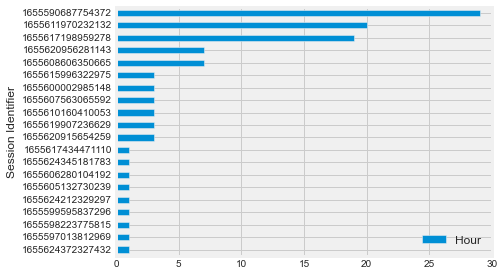

In [754]:
data.groupby(['Session Identifier']).agg({'Hour':'count'})[:20].sort_values('Hour', ascending=True).plot(kind='barh')


# Activity for each session on Daily basis

<AxesSubplot:ylabel='Session Identifier'>

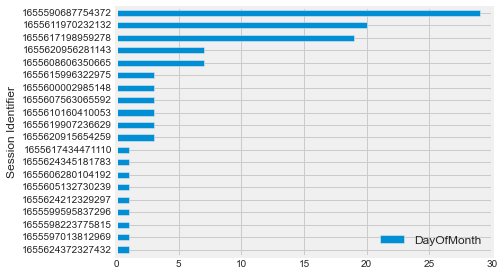

In [719]:
data.groupby(['Session Identifier']).agg({'DayOfMonth':'count'})[:20].sort_values('DayOfMonth', ascending=True).plot(kind='barh')

# TOP TEN WEBSITES VISITED

<AxesSubplot:>

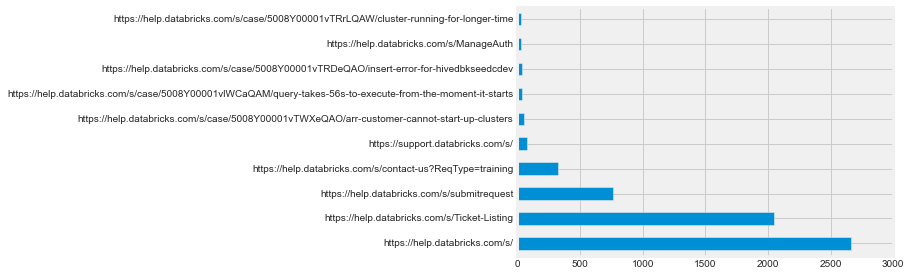

In [720]:
data['Activity Additional Detail'].value_counts()[:10].plot(kind='barh')


# Websites Visited grouped by sessions

<AxesSubplot:ylabel='Session Identifier'>

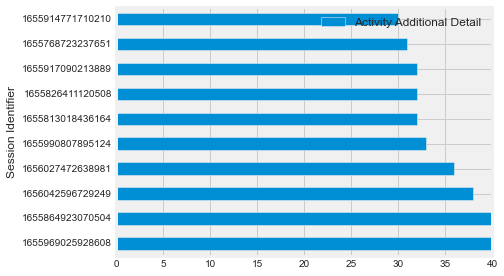

In [751]:
data_si = data.groupby(['Session Identifier'],sort=True).agg({'Activity Additional Detail': 'count'}).sort_values(by='Activity Additional Detail',ascending = False)[:10].plot(kind='barh')
data_si

# 
##Data Analysis for each feature



In [722]:
data['Searches'].value_counts()  #determines number of searches

0    12021
1     1066
Name: Searches, dtype: int64

In [723]:
data['Clicks'].value_counts() 

0    12896
1      191
Name: Clicks, dtype: int64

In [724]:
data['Cases Logged'].value_counts()

0    12498
1      589
Name: Cases Logged, dtype: int64

In [725]:
data['Activity Type'].value_counts()

Viewed Page                             10477
Visited Support                           764
Text Searched(Support Page)               597
Case Created                              589
Text Searched                             469
Clicked Search Result                     177
Clicked Search Result (Support Page)       14
Name: Activity Type, dtype: int64

<AxesSubplot:>

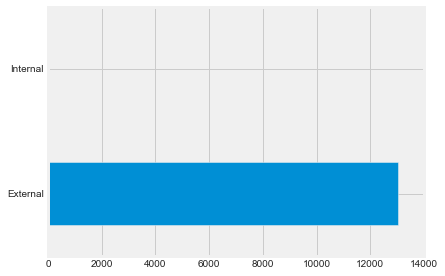

In [726]:
data['Internal/External'].value_counts().plot(kind='barh')

In [727]:
fig2 = px.histogram(data,x ='Support Visit',color='Support Visit')
fig2.show()

In [728]:
fig1 = px.histogram(data,x ='Activity Type',color='Activity Type')
fig1.show()

In [729]:
#function that to get a list of the sites by mapping the key to the webpage
def get_site_name(site_key, site_dictionary):
    site_list = []
    for i in range(len(site_key)):
        for key, value in site_dictionary.items():
            if value == site_key[i]:
                site_list.append(key)
    return site_list

# DIFFERENCE in START AND END TIME 

In [730]:
data['Session Start Time'] = pd.to_datetime(data['Session Start Time'], errors='coerce')
data['Session last Activity Time'] = pd.to_datetime(data['Session last Activity Time'], errors='coerce')

In [731]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13087 entries, 0 to 13086
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Session Identifier          13087 non-null  int64         
 1   Searches                    13087 non-null  int64         
 2   Clicks                      13087 non-null  int64         
 3   Cases Logged                13087 non-null  int64         
 4   Support Visit               13087 non-null  object        
 5   Session Start Time          13087 non-null  datetime64[ns]
 6   Session last Activity Time  13087 non-null  datetime64[ns]
 7   Activity Type               13087 non-null  object        
 8   Activity Detail             13087 non-null  object        
 9   Internal/External           13087 non-null  object        
 10  Activity Additional Detail  12021 non-null  object        
 11  Search Result Count         1066 non-null   float64   

In [732]:
data['difftime'] = data['Session last Activity Time'] - data['Session Start Time'] 

In [733]:
data['difftime_seconds'] = (data['Session last Activity Time'] - data['Session Start Time']).dt.total_seconds()

# GROUPING AND AGGREGATING
https://stackoverflow.com/questions/57893148/how-to-aggregate-dataframe-by-user-with-session-scope-complexity

In [734]:
data6 = data.groupby(['Session Identifier']).agg({'difftime_seconds':'max','Searches': 'max','Clicks':'max', 'Cases Logged':'max','Support Visit':lambda x: ' '.join(set(x)),'Activity Type':lambda x: ' '.join(set(x)),'Activity Detail':lambda x: ' '.join(set(x))})

In [735]:
data6.head()

,difftime_seconds,Searches,Clicks,Cases Logged,Support Visit,Activity Type,Activity Detail
Session Identifier,,,,,,,
1655590687754372,9527.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Ticket Listing Genie | 00185655 Query about az...
1655597013812969,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655598223775815,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655599595837296,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655600002985148,15.0,0,0,0,Not Visited Support,Viewed Page,Ticket Detail Case Detail


# CASES LOGGED WITH/WITHOUT CLICKS



In [736]:
data6[(data6['Cases Logged'] == 1) & (data6['Clicks'] == 0)]

,difftime_seconds,Searches,Clicks,Cases Logged,Support Visit,Activity Type,Activity Detail
Session Identifier,,,,,,,
1655590687754372,9527.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Ticket Listing Genie | 00185655 Query about az...
1655608606350665,200.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Databricks SQL queries failing | 00185659 Tick...
1655632334320246,483.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,sql parameter isn't being ignored when comment...
1655680099918820,1772.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,2206170030001478 Ticket Listing Ticket Detail ...
1655682095496105,621.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Ticket Detail sql能在开源spark上正常执行，但是在databricks上...
...,...,...,...,...,...,...,...
1656138722836858,426.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Ticket Listing 2206250040000042 - genie access...
1656166404945477,222.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Change of support ownership. | 00187270 Help C...
1656226715983344,739.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,remote rpc error Remote RPC error | 00187312 H...


# SESSION WITH LESS THAN 10 minutes

In [737]:
data6.loc[data6['difftime_seconds'] < 600]

,difftime_seconds,Searches,Clicks,Cases Logged,Support Visit,Activity Type,Activity Detail
Session Identifier,,,,,,,
1655597013812969,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655598223775815,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655599595837296,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
1655600002985148,15.0,0,0,0,Not Visited Support,Viewed Page,Ticket Detail Case Detail
1655605132730239,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks
...,...,...,...,...,...,...,...
1656284682125030,0.0,0,0,0,Not Visited Support,Viewed Page,Contact Us
1656285393673710,437.0,1,0,1,Visited Support,Case Created Viewed Page Text Searched(Support...,Help Center - Databricks Case Detail unable to...
1656285753732750,0.0,0,0,0,Not Visited Support,Viewed Page,Help Center - Databricks


# PREPROCESSING OF THE DATA¶

In [738]:
# Group by Session_ID
grouped_df = data.groupby('Session Identifier').agg({'Activity Detail':list})
 
# Join all queries in a cases
grouped_df['Activity Detail'] = grouped_df['Activity Detail'].apply(lambda x: ' '.join(x))
 
# Create a list of grouped queries
# for each title. 
queries = list(grouped_df['Activity Detail'])
queries

['Ticket Detail Ticket Listing Ticket Detail genie Genie | 00185655 Get Support Ticket Listing Help Center - Databricks Ticket Detail Ticket Listing Ticket Detail Ticket Listing Ticket Detail Ticket Listing Help Center - Databricks Ticket Detail Ticket Listing Help Center - Databricks Ticket Detail Ticket Listing Help Center - Databricks Ticket Detail Ticket Listing Help Center - Databricks Ticket Detail Query about azure resources required to improve databricks processing | 00185652 query about azure resources required to improve databricks processing Get Support Help Center - Databricks',
 'Help Center - Databricks',
 'Help Center - Databricks',
 'Help Center - Databricks',
 'Ticket Detail Case Detail Case Detail',
 'Help Center - Databricks',
 'Ticket Detail',
 'Ticket Detail Ticket Listing Help Center - Databricks',
 'Ticket Detail databricks sql queries failing Databricks SQL queries failing | 00185659 Get Support Ticket Listing Help Center - Databricks Help Center - Databricks',


In [739]:
vec = TfidfVectorizer(stop_words='english')
X = vec.fit_transform(queries)
tf_idf_norm = normalize(X)
tf_idf_array = tf_idf_norm.toarray()
tfidf = pd.DataFrame(tf_idf_array, columns=vec.get_feature_names())
 

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



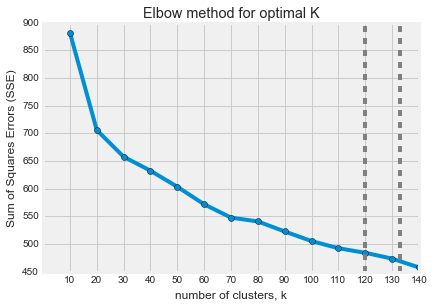

In [740]:
# Run elbows in groups of 10
# Limit to a max of the total num cases
ks = [i * 10 if i*10 < len(grouped_df) else len(grouped_df) for i in range(1,15)]
sse = []
 
for k in ks:
    model =  KMeans(
        n_clusters=k, 
        init='k-means++',
        max_iter=100,
        n_init=1)
 
    model.fit(X)
 
    sse.append(model.inertia_)
     
# Plot ks vs SSE
plt.plot(ks, sse, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Sum of Squares Errors (SSE)')
plt.title('Elbow method for optimal K')
plt.axvline(x=120,linestyle='--',c='grey')
plt.axvline(x=133,linestyle='--',c='grey')
plt.xticks(ks)
plt.show()

# silhoutte_score
#https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

In [741]:
range_n_clusters = [30, 40, 50, 60,70,80,90,100,120,133,135,140]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    #visualizer = SilhouetteVisualizer(clusterer,colors =  'yellowbrick')
    #Fit the data to the visualizer
    #visualizer.fit(X)       
    #Render the figure
    #visualizer.show()

For n_clusters = 30 The average   silhoutte_score is : 0.6353493252831389
For n_clusters = 40 The average   silhoutte_score is : 0.6414635527006192
For n_clusters = 50 The average   silhoutte_score is : 0.65307037988249
For n_clusters = 60 The average   silhoutte_score is : 0.6531761603395239
For n_clusters = 70 The average   silhoutte_score is : 0.6612249525806339
For n_clusters = 80 The average   silhoutte_score is : 0.6727734100528011
For n_clusters = 90 The average   silhoutte_score is : 0.672430313775592
For n_clusters = 100 The average   silhoutte_score is : 0.683929003442826
For n_clusters = 120 The average   silhoutte_score is : 0.6841007588705523
For n_clusters = 133 The average   silhoutte_score is : 0.6856787278718689
For n_clusters = 135 The average   silhoutte_score is : 0.6752638392237998
For n_clusters = 140 The average   silhoutte_score is : 0.6869945390620947


# KMeans Clustering

In [742]:
# define number of categories (clusters)
k = 50
 
# Instantiate the model
model = KMeans(
    n_clusters=k, 
    init='k-means++', 
    max_iter=100, 
    n_init=1,
random_state=42)
 
# Train the model on X
model.fit(X)

KMeans(max_iter=100, n_clusters=50, n_init=1, random_state=42)

In [743]:
# assign predicted clusters
labels = model.labels_
#print(len(labels)) 
# create a dataframe that contains 
# clusters matched to pages and their queries 
mapping = list(zip(labels, grouped_df.index, queries))
clusters = pd.DataFrame(mapping, columns=['cluster','Session Identifier','Activity Detail'])
clusters.head(10)

,cluster,Session Identifier,Activity Detail
0,1,1655590687754372,Ticket Detail Ticket Listing Ticket Detail gen...
1,2,1655597013812969,Help Center - Databricks
2,2,1655598223775815,Help Center - Databricks
3,2,1655599595837296,Help Center - Databricks
4,5,1655600002985148,Ticket Detail Case Detail Case Detail
5,2,1655605132730239,Help Center - Databricks
6,3,1655606280104192,Ticket Detail
7,40,1655607563065592,Ticket Detail Ticket Listing Help Center - Dat...
8,26,1655608606350665,Ticket Detail databricks sql queries failing D...
9,0,1655610160410053,Contact Us Help Center - Databricks Help Cente...


In [744]:
# Dimensionality reduction
# Reduce features to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X.toarray())
 
# Reduce centroids to 2D
reduced_centroids = pca.transform(model.cluster_centers_)
 
print('Tf-IDF feature size: ', X.toarray().shape)
print('PCA feature size: ', reduced_features.shape)
print('Tf-IDF cluster centroids size: ', model.cluster_centers_.shape)
print('PCA centroids size: ', reduced_centroids.shape)

Tf-IDF feature size:  (3822, 2057)
PCA feature size:  (3822, 2)
Tf-IDF cluster centroids size:  (50, 2057)
PCA centroids size:  (50, 2)


In [745]:
pca_df_scale = pd.DataFrame(reduced_features, columns=['pc1','pc2'])
print(pca.explained_variance_ratio_)
pca_df_scale

[0.37309856 0.17377705]


,pc1,pc2
0,0.258129,-0.215756
1,-0.654353,-0.112337
2,-0.654353,-0.112337
3,-0.654353,-0.112337
4,0.432204,0.137048
...,...,...
3817,0.105598,0.298963
3818,-0.654353,-0.112337
3819,0.203301,0.936113
3820,0.285804,-0.393674


# FEATURE EXTRACTION

In [746]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, predictions, 20)

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be rem

<AxesSubplot:xlabel='score', ylabel='features'>

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from current font.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from current font.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from current font.

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning

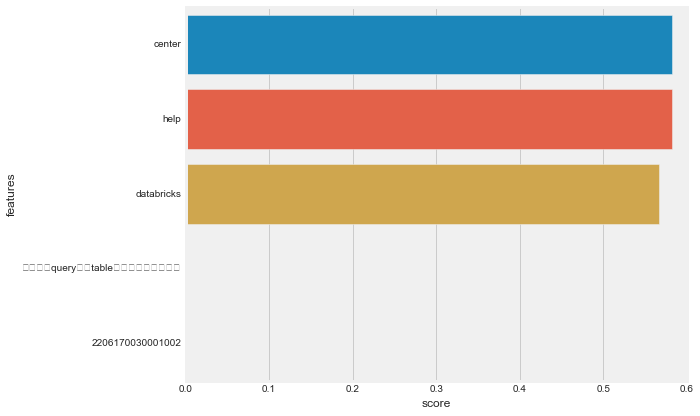

In [747]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:5])
#https://www.kaggle.com/code/dfoly1/k-means-clustering-from-scratch/notebook#Kmeans-Class

Seaborn library to visualize our grouped texts in a very simple way.

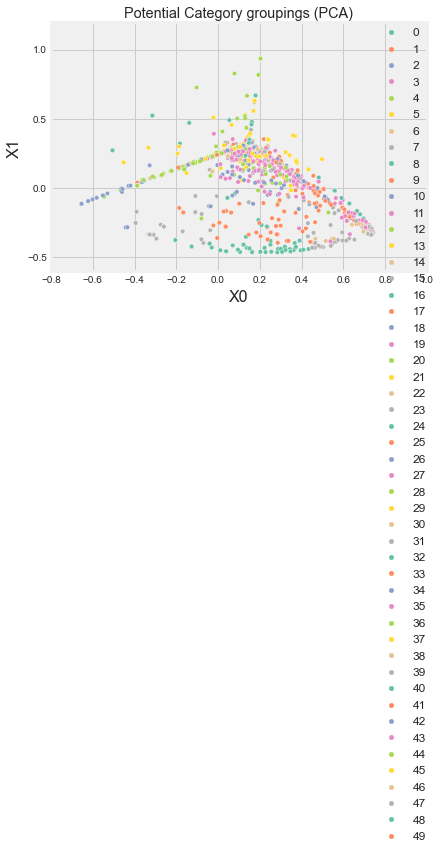

In [748]:
# Plot the individual groupings
# of cases_title

sns.scatterplot(
    x=reduced_features[:,0],
    y=reduced_features[:,1],
    hue=clusters['cluster'],
    palette='Set2')
 
# # plot the cluster centroids
# #for i in range(5):
# plt.scatter(
#     reduced_centroids[:, 0],
#     reduced_centroids[:,1],
#     marker='x',
#     s=30,
#     c='k'
#     )
 
# plot the graph
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
#ax1.rcParams["figure.figsize"] = (20, 15)
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
plt.title('Potential Category groupings (PCA)')
plt.show()


In [749]:
#https://www.kaggle.com/code/leomauro/text-clustering-grouping-texts
